In [1]:
import numpy as np
from numpy import nan
import matplotlib.pyplot as plt
import pandas as pd
import math
import joblib
# %run 3.Xfoil_runner_extract_value.ipynb

In [2]:
x1 = pd.read_excel('design_parmeter.xlsx')
y1 = pd.read_excel('Cl_Cd.xlsx')

In [3]:
df = pd.merge(x1, y1)
df = df.dropna()
df.to_excel('dataset.xlsx')
df

,Unnamed: 0,x1,x2,x3,x4,x5,x6,x7,x8,CL,CD
0,0,0.0084,0.0104,-0.0033,-0.0033,-0.0086,0.0015,-0.0019,-0.0027,0.5294,0.00733
1,1,-0.0045,-0.0035,0.0057,0.0062,0.0106,-0.0060,0.0101,0.0037,0.6747,0.00947
2,2,-0.0093,0.0038,-0.0083,-0.0113,0.0030,-0.0028,-0.0093,0.0085,0.4693,0.00959
3,3,0.0019,-0.0093,0.0067,0.0025,-0.0012,0.0077,0.0026,-0.0092,0.5034,0.00928
4,4,0.0045,0.0017,0.0026,0.0050,-0.0039,0.0034,-0.0087,0.0105,0.6249,0.00916
...,...,...,...,...,...,...,...,...,...,...,...
170,170,-0.0060,0.0105,-0.0077,0.0070,0.0105,-0.0006,-0.0042,0.0013,0.5617,0.00871
171,171,0.0051,-0.0034,0.0074,-0.0039,-0.0063,0.0069,0.0080,-0.0050,0.5940,0.00865
172,172,0.0012,0.0080,0.0017,-0.0007,-0.0096,0.0057,-0.0017,0.0034,0.5929,0.00802
173,173,-0.0116,-0.0028,-0.0012,0.0094,0.0071,-0.0108,0.0100,-0.0030,0.5663,0.00997


In [4]:
len(df)

167

In [5]:
X = df[['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8'] ]
y = df[['CL', 'CD'] ]

In [6]:
X

,x1,x2,x3,x4,x5,x6,x7,x8
0,0.0084,0.0104,-0.0033,-0.0033,-0.0086,0.0015,-0.0019,-0.0027
1,-0.0045,-0.0035,0.0057,0.0062,0.0106,-0.0060,0.0101,0.0037
2,-0.0093,0.0038,-0.0083,-0.0113,0.0030,-0.0028,-0.0093,0.0085
3,0.0019,-0.0093,0.0067,0.0025,-0.0012,0.0077,0.0026,-0.0092
4,0.0045,0.0017,0.0026,0.0050,-0.0039,0.0034,-0.0087,0.0105
...,...,...,...,...,...,...,...,...
170,-0.0060,0.0105,-0.0077,0.0070,0.0105,-0.0006,-0.0042,0.0013
171,0.0051,-0.0034,0.0074,-0.0039,-0.0063,0.0069,0.0080,-0.0050
172,0.0012,0.0080,0.0017,-0.0007,-0.0096,0.0057,-0.0017,0.0034
173,-0.0116,-0.0028,-0.0012,0.0094,0.0071,-0.0108,0.0100,-0.0030


In [7]:
y

,CL,CD
0,0.5294,0.00733
1,0.6747,0.00947
2,0.4693,0.00959
3,0.5034,0.00928
4,0.6249,0.00916
...,...,...
170,0.5617,0.00871
171,0.5940,0.00865
172,0.5929,0.00802
173,0.5663,0.00997


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import KFold

from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dropout

In [9]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true = tf.where(tf.equal(y_true, 0.0), 1e-10, y_true)
    ape = tf.abs((y_true - y_pred) / y_true)*100
    ape = tf.where(tf.math.is_finite(ape), ape, 0.0)
    mape = tf.reduce_mean(ape)
    
    return mape

In [10]:
def root_mean_squared_error(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

In [11]:
def cal_mape(X,y, model):
    predictions = model.predict(X)
    y = y = np.array(y)
    absolute_errors = np.abs(predictions - y)
    percentage_errors = (absolute_errors / np.abs(y)) * 100
    mape_Cl = np.mean(percentage_errors[:, 0])  
    mape_Cd = np.mean(percentage_errors[:, 1]) 
    return mape_Cl, mape_Cd

In [12]:
def KFOLD_CROSS_VAL(X, y, n_fold, neurons ,activation, loss_func, epoch, batch_size):
    kf = KFold(n_splits=n_fold, shuffle=True)
    num_rows = 0
    num_cols = 4
    loss_score = np.empty((num_rows, num_cols))
    
    for train_index, val_index in kf.split(X, y):
        X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
        y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]
        scaler = StandardScaler()
        X_train_fold = scaler.fit_transform(X_train_fold)
        X_val_fold = scaler.transform(X_val_fold)
        
        from tensorflow.keras.optimizers import Adam
        optimizer = Adam(learning_rate=0.01)
        
        model = Sequential()
        model.add(Dense(neurons, input_dim=8, activation=activation, kernel_regularizer=regularizers.l2(0.01)))
        model.add(Dense(2, activation='linear'))
        model.compile(loss=loss_func, optimizer=optimizer, metrics=['mse',tf.keras.metrics.RootMeanSquaredError(name='rmse'),'mape'])
        model.fit(X_train_fold, y_train_fold, epochs= epoch, batch_size= batch_size)
        
        # Evaluate the model
        loss = model.evaluate(X_val_fold, y_val_fold)
        loss_score = np.vstack([loss_score, np.array(loss)])
    
    # Calculate average accuracy and other metrics if needed
    average_loss = np.mean(loss_score, axis=0)
    return loss_score, average_loss

In [13]:
def ANN_model(X, y, neurons ,activation, loss_func, epoch, batch_size, validation_split):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    from tensorflow.keras.optimizers import Adam
    optimizer = Adam(learning_rate=0.01)
    
    model = Sequential()
    model.add(Dense(neurons, input_dim=8, activation=activation, kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dense(2, activation='linear'))
    model.compile(loss= loss_func, optimizer=optimizer, metrics=['mse',tf.keras.metrics.RootMeanSquaredError(name='rmse'),'mape'])
    history = model.fit(X_train, y_train, epochs=epoch, batch_size=batch_size, validation_split=validation_split)
    loss = model.evaluate(X_test, y_test)

    cl_train, cd_train = cal_mape(X_train,y_train, model)
    cl_test, cd_test = cal_mape(X_test,y_test, model)
    return model, scaler, loss, history, cl_train, cd_train, cl_test, cd_test

In [14]:
def Validation_curves(history):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()

In [15]:
n_fold = 5
# neurons_list = [4,6,8,10,12,14,16]
activation = 'tanh'
loss_func = 'mean_absolute_error'
epoch = 200
batch_size = 16
mae= []
mse = []
RMSE = []
mape = []

In [21]:
neurons = 14
activation = 'tanh'
loss_func = 'mean_absolute_error'
epoch = 200
batch_size = 16
validation_split = 0.2

In [22]:
model, scaler, loss, history, cl_train, cd_train, cl_test, cd_test = ANN_model(X, y, neurons ,activation, loss_func, epoch, batch_size, validation_split)

Epoch 1/200
7/7 [==============================] - 1s 46ms/step - loss: 0.6603 - mse: 0.4641 - rmse: 0.6813 - mape: 3432.2429 - val_loss: 0.5117 - val_mse: 0.2412 - val_rmse: 0.4912 - val_mape: 2433.4536
Epoch 2/200
7/7 [==============================] - 0s 8ms/step - loss: 0.3419 - mse: 0.1035 - rmse: 0.3217 - mape: 1356.6459 - val_loss: 0.2441 - val_mse: 0.0386 - val_rmse: 0.1965 - val_mape: 724.2296
Epoch 3/200
7/7 [==============================] - 0s 8ms/step - loss: 0.2294 - mse: 0.0334 - rmse: 0.1827 - mape: 843.5913 - val_loss: 0.2306 - val_mse: 0.0353 - val_rmse: 0.1880 - val_mape: 970.6682
Epoch 4/200
7/7 [==============================] - 0s 8ms/step - loss: 0.2037 - mse: 0.0253 - rmse: 0.1589 - mape: 754.3350 - val_loss: 0.1934 - val_mse: 0.0268 - val_rmse: 0.1638 - val_mape: 621.6933
Epoch 5/200
7/7 [==============================] - 0s 8ms/step - loss: 0.1672 - mse: 0.0162 - rmse: 0.1274 - mape: 520.0513 - val_loss: 0.1649 - val_mse: 0.0159 - val_rmse: 0.1262 - val_mape: 

In [23]:
loss

[0.013454534113407135,
 0.0005776715697720647,
 0.02403480000793934,
 5.41831636428833]

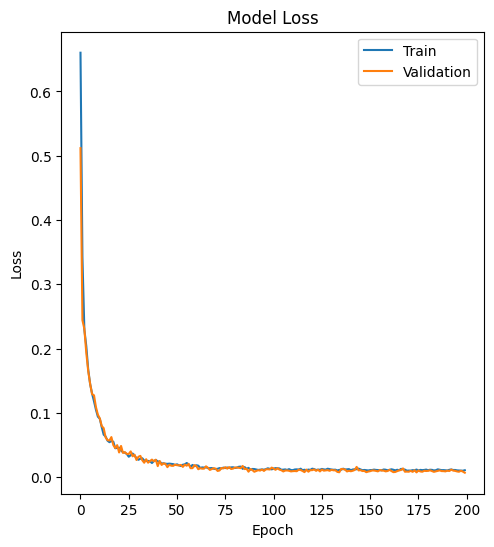

In [24]:
Validation_curves(history)

In [25]:
print (cl_train, cd_train, cl_test, cd_test)

2.9618021995249144 5.234858003845112 4.262886395405352 6.573747606297244


In [26]:
# joblib.dump(model, 'model__24_rmse.joblib')
# joblib.dump(scaler, 'scaler_file__24_rmse.joblib')

['scaler_file__24_rmse.joblib']